In [1]:
1+1

2

In [2]:
import numpy as np
import pylab as plt

import sys
sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/')
from Plot_utilities import *
from Object_utilities import *
from PostProcessing import *

from Orthogonalization_real_space import *
from StrainTiltCalculation import *

from CreateVTI import *

my_cmap = MIR_Colormap()

In [3]:
# path_reconstruction = 'Reconstructions_CropAlgo/Pd_4_5e16_h5file_Pd_4_5e16_BCDI_x3_scan5_background3/'
# path_reconstruction = 'Reconstructions_CropAlgo/PtYSZ_h5file_PtYSZ_0001_scan54_inpainted/'
# path_reconstruction = 'Reconstructions_CropAlgo/CA_holder4_homo_h5file_CA_holder4_homo_BCDI_0005_scan30_average_scans_3_6_9_12_15_18_21_24_27_30/'
# path_reconstruction = 'Reconstructions_CropAlgo/CA_holder5_hetero_new_hope_h5file_CA_holder5_hetero_new_hope_BCDI_0060_scan6_rebin_2_1_1_background1/'
path_reconstruction = 'Reconstructions_CropAlgo/Pd_GC_0002_scan64/'

In [4]:
obj_list, llk_list, file_list = load_reconstructions(path_reconstruction)
print(len(obj_list))

# Sort the obj_list array if you want (can take a bit of time for 3D data)
metric_string = 'module_std'
# metric_string = 'module max position'
obj_list, llk_list, file_list = sort_object_list_metric(obj_list, llk_list=llk_list, file_list=file_list,
                                                        metric_string = metric_string)

3


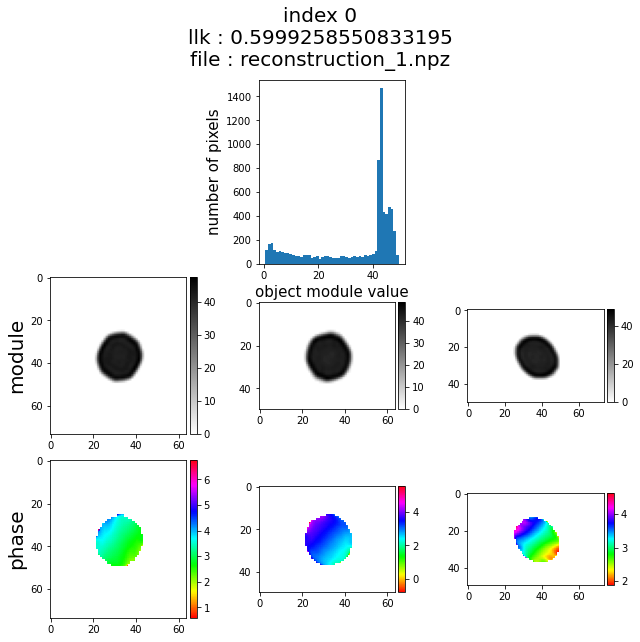

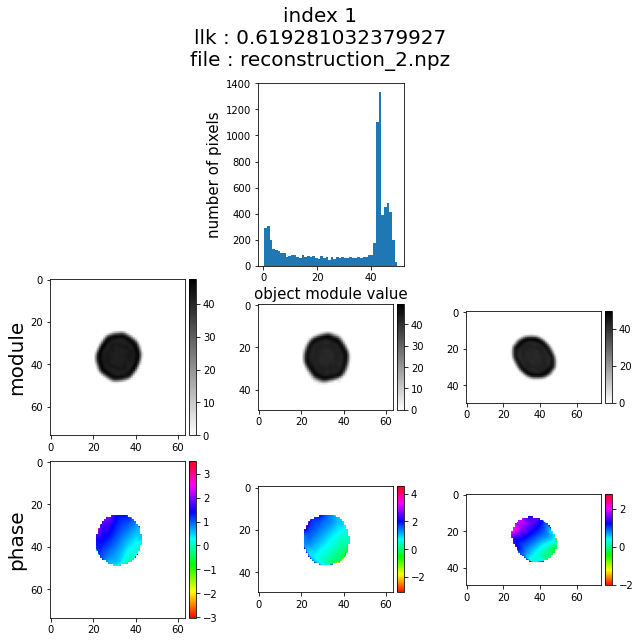

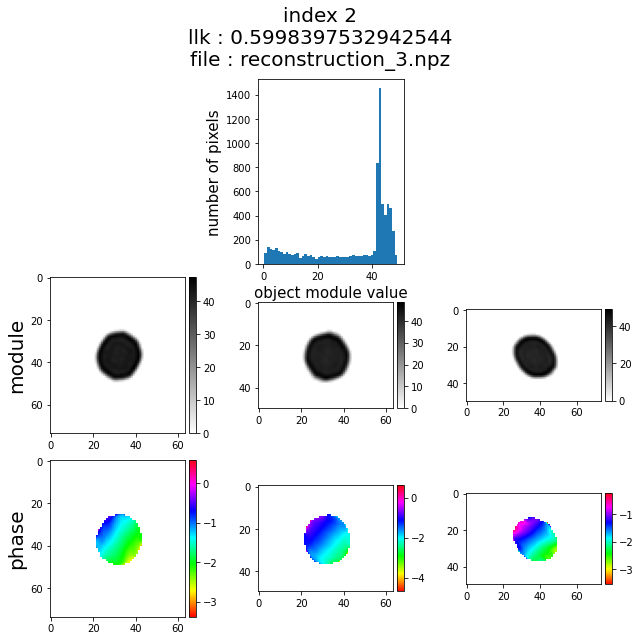

In [5]:
for n,obj in enumerate(obj_list[:6]):
# for n,obj in enumerate(obj_list):
    fig,ax = plt.subplots(3,3, figsize=(9,9))
    plot_2D_slices_middle_and_histogram(obj, fig=fig, ax=ax)
    fig.suptitle('index {}\nllk : {}\nfile : {}'.format(n, llk_list[n], file_list[n].split('/')[-1]), fontsize=20)
    fig.tight_layout()

mode 1 : 99.1 %
mode 2 : 0.85 %
mode 3 : 0.05 %
oversampling ratio : [4.16666667 6.25       5.90909091]


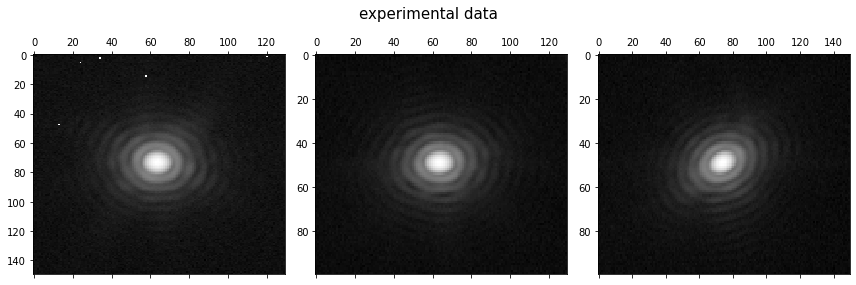

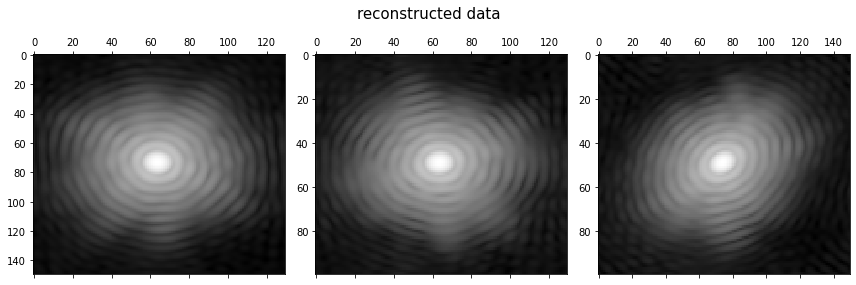

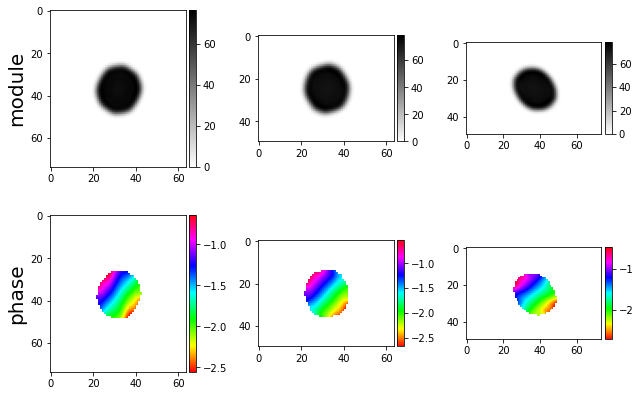

In [6]:
oversampling_check = True
apodization = True
large_phase_ramp = False

index_best_recon = [0,1,2] 
conj_index = 'auto'


obj, file_ref, weights = combine_reconstructions(file_list, index_best_recon,
                            conj_index=None, conj_index_start=0,
                            apodization = apodization,
                            large_phase_ramp = large_phase_ramp)

In [7]:
# axis = 1
# interactive_3d_object(obj, axis=axis, threshold_module=.3)

In [8]:
# %matplotlib inline

# Real space orthogonalization

rotate axes such that the Bragg is along the last axis
voxel size (Angstrom) :  [100, 100, 100]


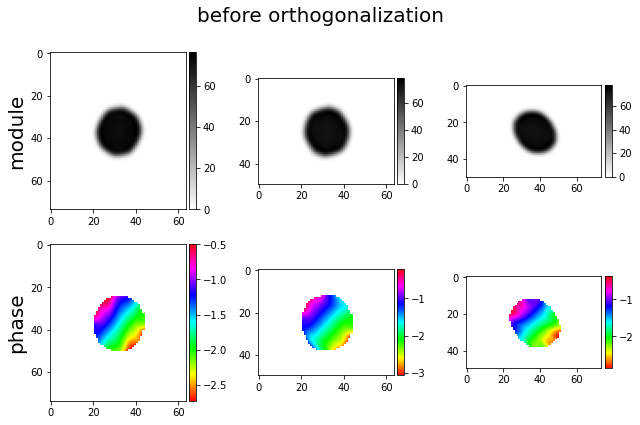

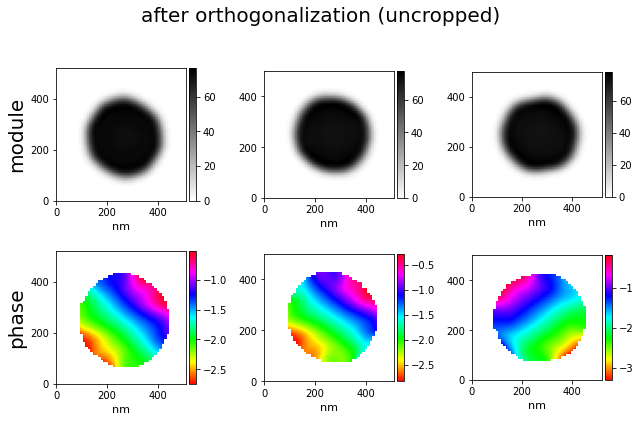

In [37]:
rotate_bragg_to_last_axis = True # False
# Maybe better to keep it to False

voxel_sizes = None # 100 # [100,120,130]

obj_ortho, voxel_sizes, qcen = real_space_orthogonalization(obj, file_ref, 
                                                            voxel_sizes = voxel_sizes,
                                                            rotate_bragg_to_last_axis=rotate_bragg_to_last_axis,
                                                            
                                 plot=True)

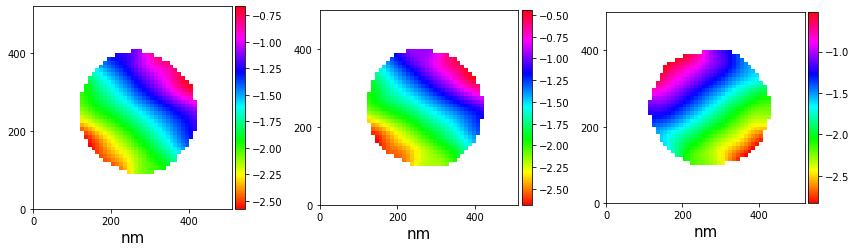

In [38]:
# Select a threshold_module to get a clean phase
threshold_module = .4
# threshold_module = .4
plot_2D_slices_middle_only_phase(obj_ortho, threshold_module=threshold_module, voxel_sizes=voxel_sizes, fw=4,
                                 crop=False)

module_ortho, phase_ortho = get_cropped_module_phase(obj_ortho, crop=False, unwrap=True, threshold_module=threshold_module)

In [39]:
phase_ramp_removal = False

if phase_ramp_removal:
    obj_ortho = remove_phase_ramp(obj_ortho,
                          threshold_module=threshold_module,
                          crop=False,
                          return_ramp=False,
                          plot=False)

take into account defects


/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/StrainTiltCalculation.py:26: RuntimeWarning: Mean of empty slice
  grad_n = np.nanmean([grad_n[tuple(slice1)], grad_n[tuple(slice2)]], axis=0)


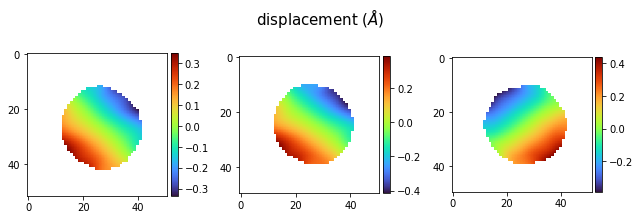

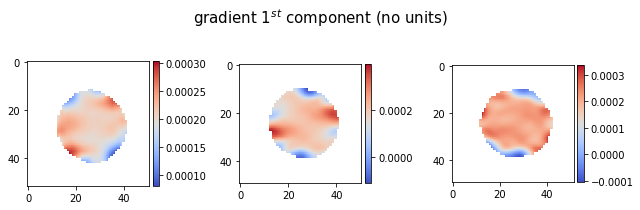

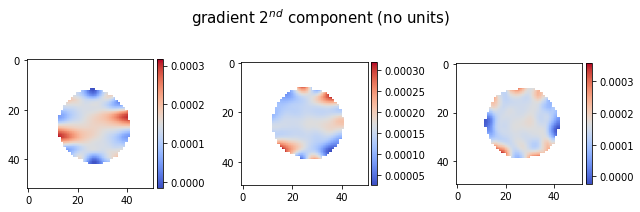

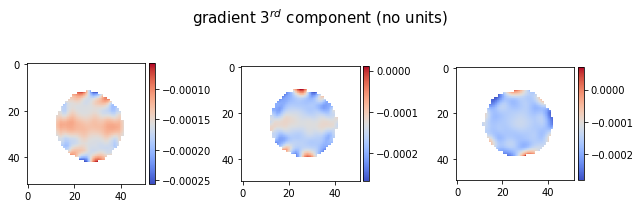

In [40]:
defect = True

displacement, grad = displacement_and_gradient(obj_ortho, qcen,
                              voxel_sizes=voxel_sizes,
                              unwrap=True, crop=False, threshold_module=threshold_module,
                              use_negative_phase=True,
                              defect=defect, phase_shift=np.pi/2.,
                                              plot=True)

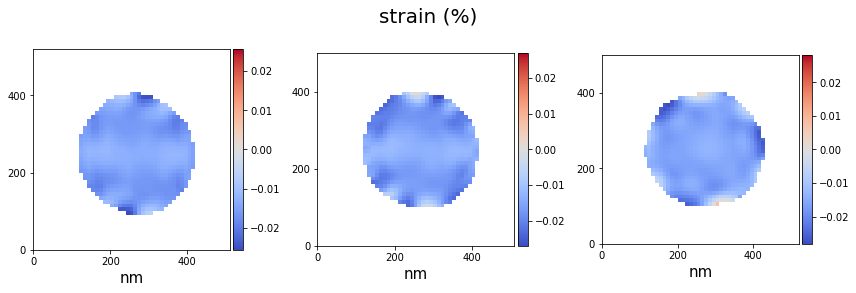

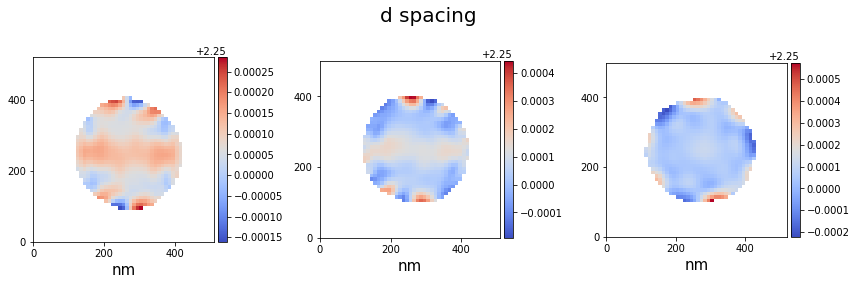

In [41]:
strain, d_spacing = compute_strain(grad, qcen, plot=True, voxel_sizes=voxel_sizes)

In [42]:
# Center the strain if needed
strain = strain - np.nanmean(strain)

In [43]:
# axis = 2
# interactive_3d_array(d_spacing, axis=axis, voxel_sizes=voxel_sizes)

In [44]:
# %matplotlib inline

# Tilt maps

e_bragg :  [-5.57475974e-21  1.41465307e-18  1.00000000e+00]
e1 :  [ 1.00000000e+00 -0.00000000e+00  5.57475974e-21]
e2 :  [ 7.88635100e-39  1.00000000e+00 -1.41465307e-18]
all values below should be 1
check 1 1.0
check 2 1.0
check 3 1.0

all values below should be 0
check 4 0.0
check 5 0.0
check 6 6.454168827093723e-55


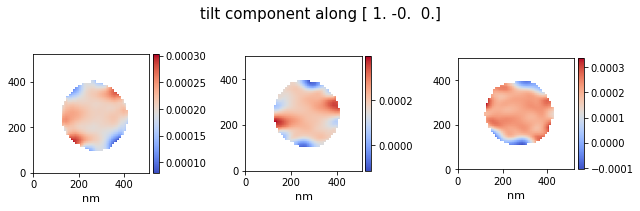

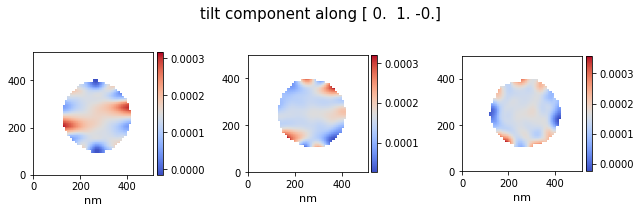

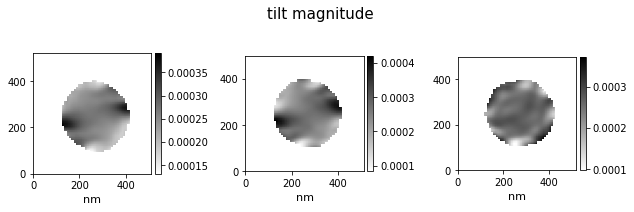

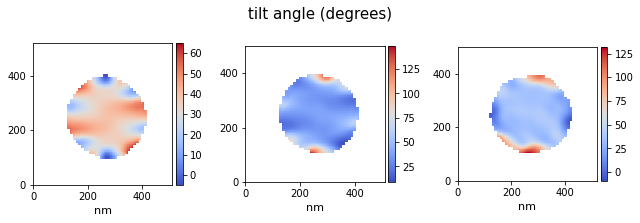

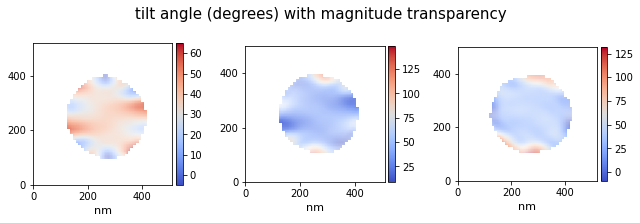

In [45]:
tilt_comp1, tilt_comp2, tilt_magn, tilt_angle, e1, e2 = compute_tilt(grad, qcen,
                                     polar_representation=True,
                 check=True, plot=True, voxel_sizes=voxel_sizes)

# Make a nice figure

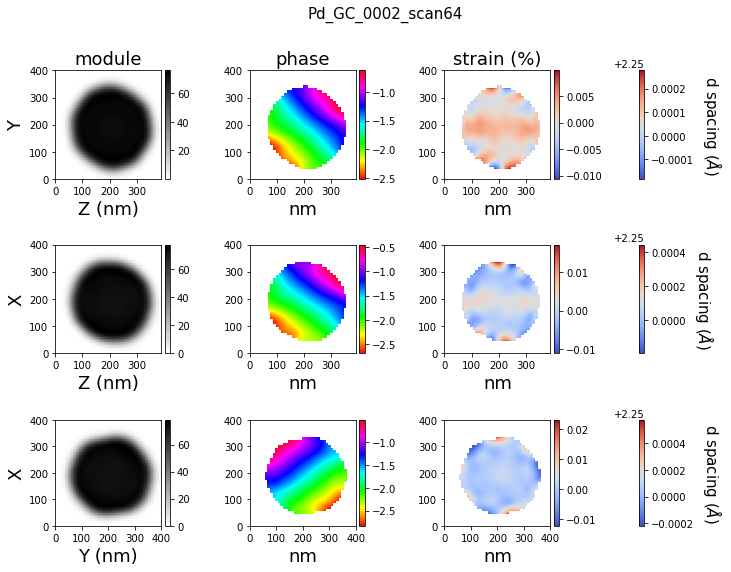

In [46]:
final_figure_version3(module_ortho, phase_ortho, 
                      strain, d_spacing,
                 voxel_sizes=voxel_sizes, fig_title=path_reconstruction.split('/')[-2])

In [47]:
# final_figure_version2(module_ortho, phase_ortho, 
#                       strain,
#                           tilt_comp1, tilt_comp2, 
#                  voxel_sizes=voxel_sizes)

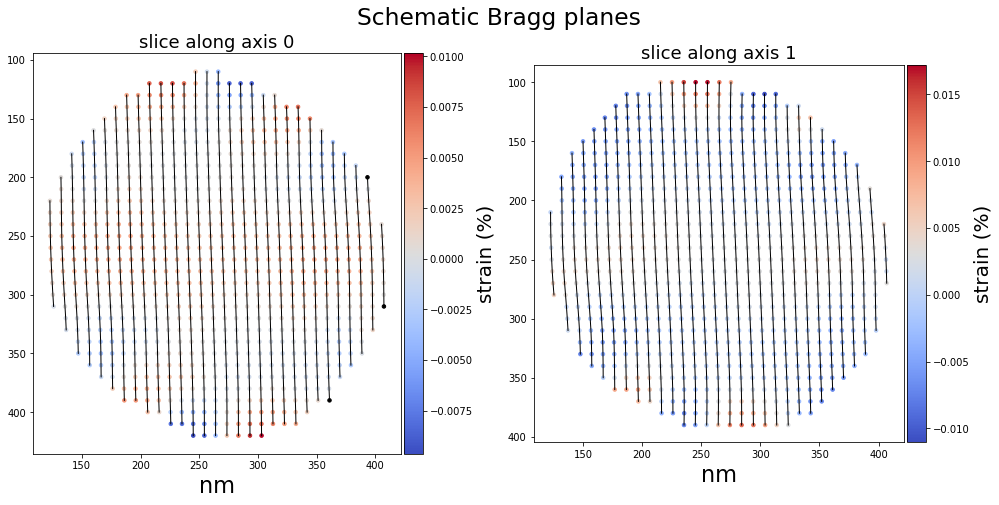

In [48]:
visual_factor = 200
dislo_threshold = 10

final_figure_schematic_Bragg_planes(displacement, qcen, voxel_sizes,
                                  strain=strain,
                                  visual_factor=visual_factor, dislo_threshold=dislo_threshold,
                                  close_roi=True, fw=7)

Maybe could change the object orientation since Bragg is often vertical in the lab frame. To be seen later.

/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/Plot_utilities.py:984: RuntimeWarning: Mean of empty slice
  surface_strain = np.nanmean(surface_strain, axis=axis)
/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/Plot_utilities.py:1034: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


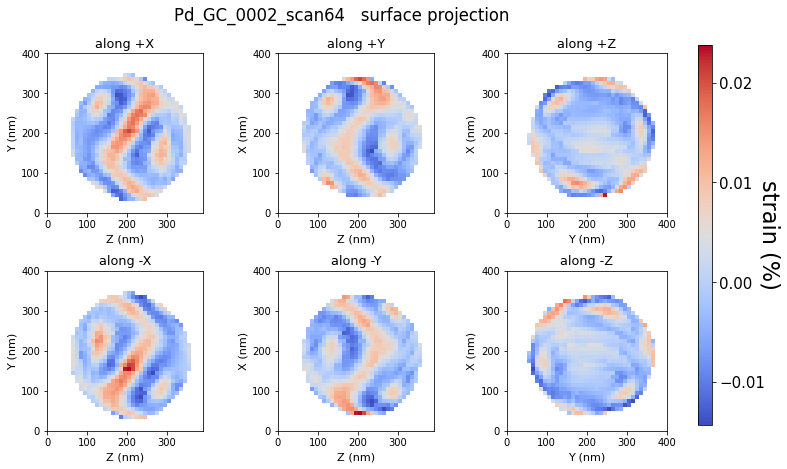

In [49]:
roi = automatic_object_roi(obj_ortho, factor=.2)

plot_surface_projections(apply_roi(strain, roi), voxel_sizes, fig_title=path_reconstruction.split('/')[-2],
                        vmin=None, vmax=None)

# Save the object

In [50]:
additional_dict = {}
additional_dict['mode'] = weights
additional_dict['qcen_labspace'] = file_ref['qcen']
additional_dict['qcen'] = qcen
additional_dict['module_ortho'] = module_ortho
additional_dict['phase_ortho'] = phase_ortho
additional_dict['displacement'] = displacement
additional_dict['tilt_magn'] = tilt_magn
additional_dict['tilt_angle'] = tilt_angle
additional_dict['tilt_comp1'] = tilt_comp1
additional_dict['tilt_comp2'] = tilt_comp2


save_final_object(obj_ortho, strain, d_spacing, voxel_sizes,
                      file_ref, 
                      path_reconstruction,
                  additional_dict=additional_dict,
                      verbose=True)

final object saved at :  Reconstructions_CropAlgo/Pd_GC_0002_scan64//final_obj/final_object.npz


# Save VTI

problem, Nb_surface_pixels_added should be less than 9. I overwrite it.
10 9 8 7 6 5 4 3 2 1 problem, Nb_surface_pixels_added should be less than 9. I overwrite it.
10 9 8 7 6 5 4 3 2 1 problem, Nb_surface_pixels_added should be less than 9. I overwrite it.
10 9 8 7 6 5 4 3 2 1 

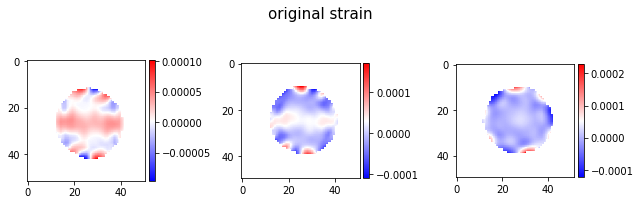

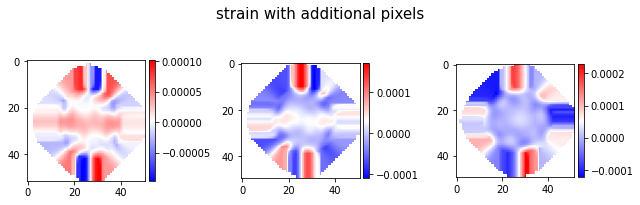

In [51]:
Nb_surface_pixels_added = 10
strain_paraview = add_surface_pixels(strain, Nb_surface_pixels_added = Nb_surface_pixels_added, plot=True)
tilt_comp1_paraview = add_surface_pixels(tilt_comp1, Nb_surface_pixels_added = Nb_surface_pixels_added)
tilt_comp2_paraview = add_surface_pixels(tilt_comp2, Nb_surface_pixels_added = Nb_surface_pixels_added)

In [52]:
module_ortho, phase_ortho = get_cropped_module_phase(obj_ortho, threshold_module=threshold_module,crop=False)
module_ortho = module_ortho/np.max(module_ortho)
np_arrays = {'module_ortho' : module_ortho,
             'phase_ortho' : phase_ortho,
             'strain' : strain,
             'strain_paraview' : strain_paraview,
             'tilt_comp1_paraview' : tilt_comp1_paraview,
             'tilt_comp2_paraview' : tilt_comp2_paraview}
save_vti(np_arrays, 
             voxel_sizes, path_reconstruction)

vti file saved in :  Reconstructions_CropAlgo/Pd_GC_0002_scan64/final_obj/Pd_GC_0002_scan64.vti


# Remove bad reconstructions

In [53]:
delete_recon = False

if delete_recon:
    remove_bad_reconstructions(file_list,
                                   index_best_recon,
                                   verbose=True)

# Old stuffs

# Reciprocal space naive orthogonalization (only for comparison)

In [ ]:
from Orthogonalization_reciprocal_space import *

In [ ]:
obj_ortho, qx1d_ortho, qy1d_ortho, qz1d_ortho, voxel_sizes = OrthogonalizeObject(obj,
                        path_reconstruction,
                        plot=True)

In [ ]:
# Select a threshold_module to get a clean phase
threshold_module = .3
plot_2D_slices_middle_only_phase(obj_ortho, threshold_module=threshold_module, voxel_sizes=voxel_sizes)

In [ ]:
q_cen = file_ref['qcen']

strain, d_spacing = compute_strain(obj_ortho, 
                   voxel_sizes,
                   q_cen,
                   threshold_module=threshold_module,
                   verbose=True,
                   plot=True)

In [ ]:
# axis = 2
# interactive_3d_array(d_spacing, axis=axis, voxel_sizes=voxel_sizes)

In [ ]:
# %matplotlib inline

# Compute heterogenous strain

In [ ]:
obj_ortho_no_ramp = remove_phase_ramp(obj_ortho, plot=True, threshold_module=threshold_module)

In [ ]:
strain_hetero = compute_strain(obj_ortho_no_ramp, 
                   voxel_sizes,
                   q_cen,
                   threshold_module=threshold_module,
                        compute_d_spacing=False,
                   verbose=True,
                   plot=True)

In [11]:
file_ref = np.load(file_list[index_best_recon[0]],allow_pickle=True)
dico = dict(file_ref,allow_pickle=True)

# Dev. Solve the wrapping problem in displacement for the Bragg schemtic plane figure.

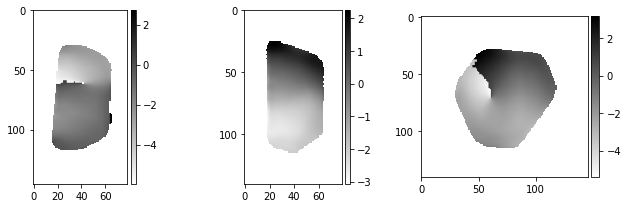

In [93]:
plot_2D_slices_middle_one_array3D(phase_ortho)

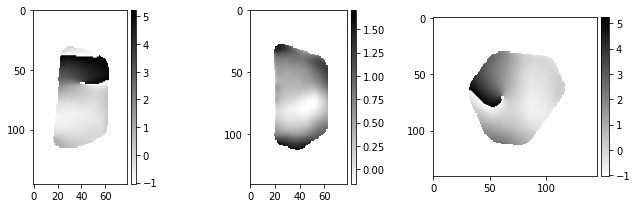

In [113]:
phase_shift = pi/3.
test = np.mod(phase_ortho + phase_shift, 2.*np.pi) - phase_shift
plot_2D_slices_middle_one_array3D(test)

In [116]:
phase = np.copy(phase_ortho)

In [117]:
grad_shift_list = []
for n in [0,1,2]:
    shifted_phase_map = np.mod(phase + n*phase_shift, 2.*np.pi)
    grad_shift_list.append(EB_custom_gradient(shifted_phase_map, voxel_sizes = voxel_sizes))

grad_clean = np.zeros(grad_shift_list[0].shape)
grad_clean[np.isnan(grad_shift_list[0])] = np.nan

for indices in [ [0,1], [0,2], [1,2] ] :
    mask = np.isclose(grad_shift_list[indices[0]], grad_shift_list[indices[1]])
    grad_clean[mask==1] = grad_shift_list[indices[0]][mask==1]

/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/StrainTiltCalculation.py:26: RuntimeWarning: Mean of empty slice
  grad_n = np.nanmean([grad_n[tuple(slice1)], grad_n[tuple(slice2)]], axis=0)


In [118]:
grad_clean.shape

(3, 141, 146, 79)

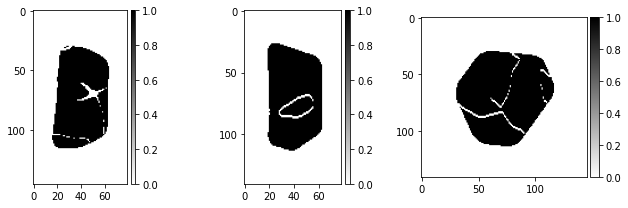

In [123]:
mask = np.isclose(grad_clean, grad_shift_list[0])
# mask = np.nanmax(mask, axis=0)
# mask = 1 - mask
plot_2D_slices_middle_one_array3D(mask[0])

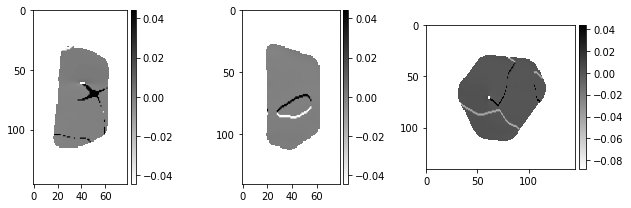

In [127]:
plot_2D_slices_middle_one_array3D(grad_shift_list[0][0])

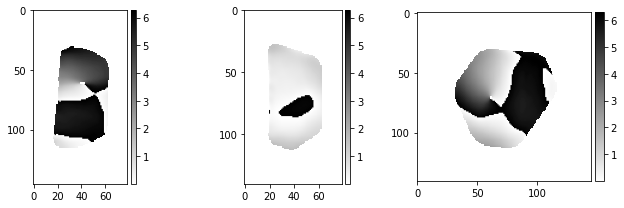

In [126]:
plot_2D_slices_middle_one_array3D(np.mod(phase, 2.*np.pi))

In [ ]:
for n in [0,1,2]:
    shifted_phase_map = np.mod(phase + n*phase_shift, 2.*np.pi)
    grad_shift_list.append(EB_custom_gradient(shifted_phase_map, voxel_sizes = voxel_sizes))

grad_clean = np.zeros(grad_shift_list[0].shape)
grad_clean[np.isnan(grad_shift_list[0])] = np.nan

for indices in [ [0,1], [0,2], [1,2] ] :
    mask = np.isclose(grad_shift_list[indices[0]], grad_shift_list[indices[1]])
    grad_clean[mask==1] = grad_shift_list[indices[0]][mask==1]

In [107]:
shift = pi/3.
test = np.abs(obj) * np.exp(1.0j*(np.angle(obj)+shift))
_, test = get_cropped_module_phase(obj_ortho, crop=False, unwrap=True, threshold_module=threshold_module)

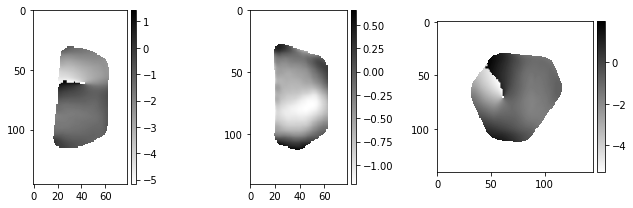

In [108]:
plot_2D_slices_middle_one_array3D(test - shift)

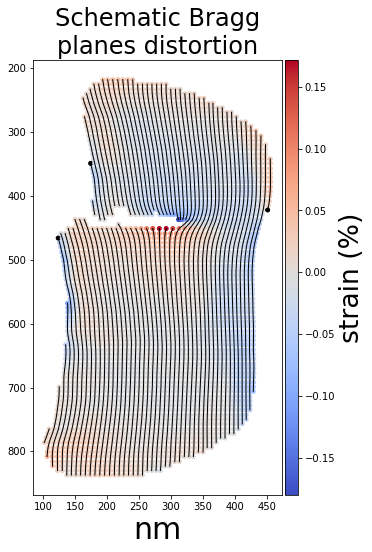

In [180]:
visual_factor = 300
schematic_Bragg_planes_figure(displacement, qcen, voxel_sizes,
                                  strain=strain,
                                  module_ortho=None,
                                  axis=0, slice_index=None,
                                  visual_factor=visual_factor,
                              dislo_threshold = 20,
                                  close_roi=True,
                                  fig=None, ax=None, fw=8, fig_title=None)